[Source](https://github.com/giakoumoglou/classification/blob/main/notebooks/main_simclr.ipynb)

# 1. Imports

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

## 2.5 Two Crop Transform
Creates two crops of the same image which are the result of a stochastic augmentation defined as a transform.

In [2]:
class TwoCropTransform:
    """Create two crops of the same image"""
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x)]

In [3]:
class Encoder(torch.nn.Module):
    "Encoder network"
    def __init__(self):
        super(Encoder, self).__init__()
        image_channels = 1
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 8, kernel_size=2, stride=2),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(8, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten()
        )

    def forward(self, x):
        return self.encoder(x)

class ProjectionHead(torch.nn.Module):
    "Projection head"
    def __init__(self, input_dim=144, hidden_dim=64, output_dim=32):
        super(ProjectionHead, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.projection_head(x)


class SupCon(nn.Module):
    """encoder + projection head"""
    def __init__(self, encoder, head):
        super(SupCon, self).__init__()
        self.encoder = encoder
        self.head = head

    def forward(self, x):
        feat = self.encoder(x)
        feat = F.normalize(self.head(feat), dim=1)
        return feat


In [4]:
"""
Author: Yonglong Tian (yonglong@mit.edu)
Date: May 07, 2020
"""
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        #src: https://github.com/giakoumoglou/classification/tree/main/notebooks
        #if no labels are provided, it is basically the SimCLRLoss #TODO check this with SimCLRLoss class
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features):
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        mask = torch.eye(batch_size, dtype=torch.float32).to(device)



        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

## 3.3 Pre-Training
Main training loop of **encoder** and **projection head** for a number of batches over an epoch, as it is defined in [PyTorch](https://pytorch.org/). Note that the loss used in the ```SupConLoss``` defined just for the pre-training. If CUDA is availiable, training will take place in GPU. ```EarlyStopping``` class is used to keep track of loss and accuracy. Returns the loss and accuracy of the epoch.  

In [5]:
def pretraining(epoch, model, contrastive_loader, optimizer, criterion):
    "Contrastive pre-training over an epoch"


    model.train()
    for batch_idx, (data,labels) in enumerate(contrastive_loader):
        data = torch.cat([data[0], data[1]], dim=0)
        if torch.cuda.is_available():
            data,labels = data.cuda(), labels.cuda()
        data, labels = torch.autograd.Variable(data,False), torch.autograd.Variable(labels)
        bsz = labels.shape[0]
        features = model(data)
        f1, f2 = torch.split(features, [bsz, bsz], dim=0)
        features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)

        loss = criterion(features)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item()

# 4. Main

In [6]:
import os
def main(num_epochs = 5):

    use_scheduler = True

    contrastive_transform = transforms.Compose([
                                    transforms.RandomResizedCrop(size=(28, 28), scale = (0.5, 0.95)),
                                    transforms.RandomRotation(degrees=45),
                                    transforms.ToTensor(),
                                       ])



    contrastive_set = datasets.MNIST('./data', download=True, train=True, transform=TwoCropTransform(contrastive_transform))

    contrastive_loader = torch.utils.data.DataLoader(contrastive_set, batch_size=64, shuffle=True)

    # Part 1
    encoder = Encoder()
    head = ProjectionHead()
    model = SupCon(encoder, head)

    criterion = SupConLoss(temperature=0.07)
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()


    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

    contrastive_loss, contrastive_lr = [], []

    for epoch in range(1, num_epochs+1):
        print('Epoch:', epoch, '/', num_epochs)
        loss  = pretraining(epoch, model, contrastive_loader, optimizer, criterion)
        if use_scheduler:
            scheduler.step()
        contrastive_loss.append(loss)
        print('-->Loss', loss)


    plt.plot(range(1,len(contrastive_loss)+1),contrastive_loss, color='b', label = 'loss')
    plt.legend(), plt.ylabel('loss'), plt.xlabel('epochs'), plt.title('Loss'), plt.show()

    return model, contrastive_loss

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17944542.81it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 478107.45it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4360504.78it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2818542.50it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch: 1 / 10
-->Loss 1.7410879135131836
Epoch: 2 / 10
-->Loss 2.0413355827331543
Epoch: 3 / 10
-->Loss 2.136378288269043
Epoch: 4 / 10
-->Loss 1.493307113647461
Epoch: 5 / 10
-->Loss 1.413617730140686
Epoch: 6 / 10
-->Loss 1.3764562606811523
Epoch: 7 / 10
-->Loss 1.2823749780654907
Epoch: 8 / 10
-->Loss 1.4445103406906128
Epoch: 9 / 10
-->Loss 1.5627812147140503
Epoch: 10 / 10
-->Loss 1.422078013420105


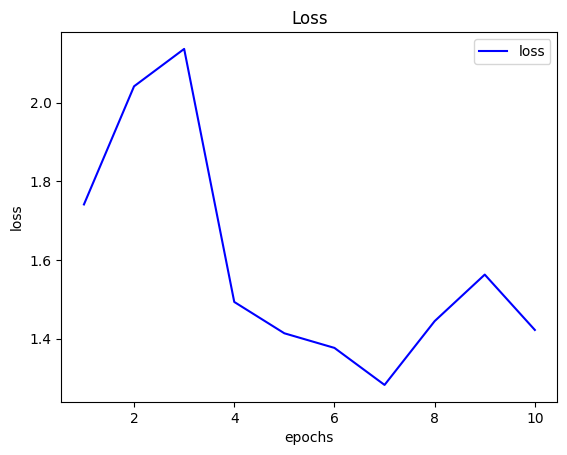

In [7]:
%matplotlib inline
model, contrastive_loss = main(10)

In [27]:
# vis_transform = transforms.Compose([
#                                 transforms.RandomResizedCrop(size=(28, 28), scale = (0.5, 0.95)),
#                                 transforms.RandomRotation(degrees=45),
#                                 transforms.ToTensor(),
#                                     ])

vis_transform = transforms.Compose([
                                transforms.ToTensor(),
                                    ])


dataset = datasets.MNIST('./data', download=True, train=True, transform=TwoCropTransform(vis_transform))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)


#get embeddings of the dataset

encoder = model.encoder

embeddings = []
labels = []


i_max = 20
for i, (data, target) in enumerate(dataloader):
    data = data[0]
    if i == i_max:
        break
    if torch.cuda.is_available():
        data = data.cuda()
    features = encoder(data)
    embeddings.append(features)
    labels.append(target)


embeddings = torch.cat(embeddings, dim=0)
labels = torch.cat(labels, dim=0)

embeddings = embeddings.cpu().detach().numpy()
labels = labels.cpu().detach().numpy()

In [28]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)

X_2d = tsne.fit_transform(embeddings)


In [29]:
len(labels)

1280

Text(0, 0.5, 'tsne2')

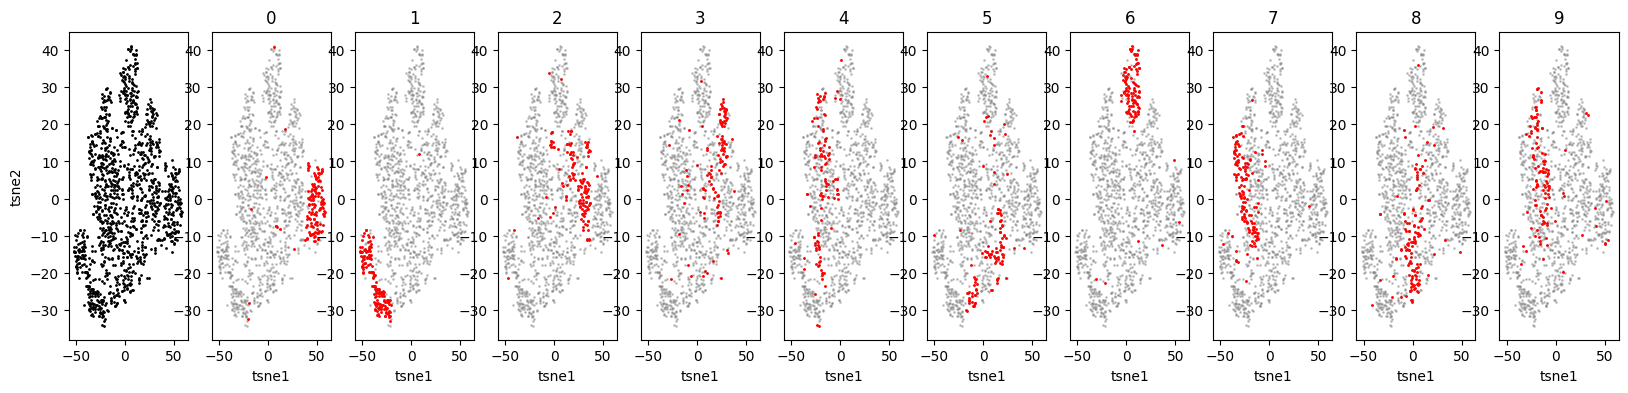

In [45]:
#tsne

limit_labels = len(labels)

#ax.scatter(X_2d[:limit_labels, 0], X_2d[:limit_labels, 1], c=labels[:limit_labels], cmap='tab10')

#plt.figure(figsize = (15,4))
fig, axs = plt.subplots(1, 11, figsize = (20,4))
axs=axs.flatten()

axs[0].scatter(X_2d[:limit_labels, 0], X_2d[:limit_labels, 1], c = 'k', s = 1)

for i in range(0,10):
  axs[i+1].scatter(X_2d[:limit_labels, 0], X_2d[:limit_labels, 1], c = 'gray', s = 1, alpha = 0.4)
  mask = labels[:limit_labels]==i
  axs[i+1].scatter(X_2d[:limit_labels, 0][mask], X_2d[:limit_labels, 1][mask], c = 'r', s = 1, alpha = 1)

  axs[i+1].set_title(i)

  axs[i+1].set_xlabel('tsne1')
axs[0].set_ylabel('tsne2')

